# Basic case

In [1]:
import numpy as np
from numba import njit


def met_tmp(lat, T = 0.0):
    N = lat.shape[0]
    n = 0
    while n < N**2:
        i,j = np.random.randint(0, N, size=2)
        delta_E = get_delta_E(i,j,lat)
        if T ==0.0:
            if delta_E <=0:
                lat[i,j] *=-1
        else:
            w = np.exp(-delta_E / T)
            r = np.random.uniform(0.,1.)
            if w>r:
                lat[i,j] *= -1
        n += 1
    
    

@njit
def get_delta_E(i, j, lat):
    
    nx, ny = lat.shape  # Original number of points along each direction
    sp = lat[i, j]

    i_1 = (i-1)%nx
    i_2 = (i+1)%nx
    j_1 = (j + 1) % ny  # PBC y-dir
    j_2 = (j - 1) % ny # PBC y-dir
    
    sum_other = lat[i_1, j] + lat[i_2, j] + lat[i, j_1] + lat[i, j_2]

    return 2 * sp * sum_other  # Difference in energy when flipping


# Mon Jasnow 
---

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import palettable as pl
emr = pl.cartocolors.sequential.Emrld_7_r.get_mpl_colormap()

In [4]:
from mon_jasnow import ising_hamiltonian, metropolis_subroutine, metropolis_MJ
from lattice_utils import get_lattice_pp,get_lattice_pm

In [5]:
N = 30
T = 1
la_pp = get_lattice_pp(N)
init_lattice = la_pp.copy()

In [6]:
%%time
for _ in range(200): # N_sweeps
    metropolis_subroutine(la_pp, T, J=1)

Wall time: 814 ms


In [7]:
%time ising_hamiltonian(la_pp, J=1.0, boundary_cond='mj')

Wall time: 1.58 s


-1630.0

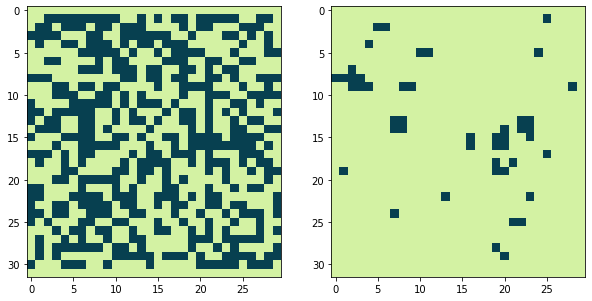

In [8]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(init_lattice, cmap=emr)
plt.subplot(122)
plt.imshow(la_pp, cmap=emr)

## Get energies

In [9]:
N_size= 32 # Size of arrays
N_avg = 20 # Number of elements average over
N_sweeps = 50 # Number of sweeps
T = 0.1
%time h_list = metropolis_MJ(N_size, N_sweeps, N_avg, T)

Wall time: 2.36 s


In [10]:
m = np.array([np.exp(-(h[1]-h[0])/(N_size**2 * T)) for h in h_list]).mean()
-T * np.log(m) * N_size

2.0000000000000013

In [11]:
Tc = 2/np.log(1+np.sqrt(2)) # critical temperature

In [12]:
T_list = np.linspace(0.001,2*Tc, 10)

In [13]:
from dask import delayed, compute

In [14]:
%%time
tau_list = np.zeros_like(T_list)
h =[]
for t in T_list:
    h_list = delayed(metropolis_MJ)(N_size, N_sweeps, N_avg, t)
    h.append(h_list)
    
res = compute(*h)

for i,t in enumerate(T_list):
    p = np.array([np.exp(-(h[1]-h[0])/(N_size**2 * t))*np.exp(-h[0]/(N_size**2 * t)) for h in res[i]])
    zp = np.array([np.exp(-h[0] / (N_size**2 * t)) for h in res[i]])
    partition_ratio  = np.sum(p) / np.sum(zp)
    tau_list[i] = -t * np.log(partition_ratio)

Wall time: 4.29 s


C:\Users\KarlKristian\Anaconda3\envs\numfys\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\Users\KarlKristian\Anaconda3\envs\numfys\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
C:\Users\KarlKristian\Anaconda3\envs\numfys\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


In [15]:
test_h = res[0][0]
e1 =np.exp(-(test_h[1]-test_h[0])/(N_size**2 * T_list[0])) 
e2 = np.exp(-test_h[0]/(N_size**2 * 0.001))
print(e1, e2)

7.187781739060989e-28 inf


C:\Users\KarlKristian\Anaconda3\envs\numfys\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 5)

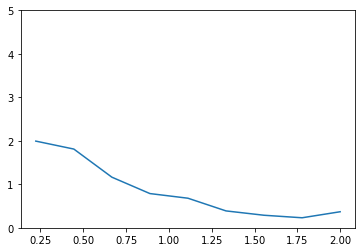

In [16]:
plt.plot(T_list/Tc, tau_list *N_size)
plt.ylim(0,5)

In [383]:
def alternative_metropolis_mj(N_size, N_sweeps, T, skips = 2):
    ev = []
    lattice_pp = get_lattice_pp(N_size)                         # Create ++ -lattice
    prev = 0                                                    # keeps track of last sampled state 
    for i in range(N_sweeps):                                   # Do N_sweep sweeps
        
        metropolis_subroutine(lattice_pp, T, J=1.0)              # Tries to flip N^2 spins
        if (i > 30) and (i>=(prev+skips)):                      # Initial sweeps, and skip sweep between each sample
            prev = i
            lattice_pm = get_lattice_pm(lattice_pp)             # Create (+-) - lattice
            E_pp = ising_hamiltonian(lattice_pp)                # Get energies
            E_pm = ising_hamiltonian(lattice_pm)
            ev.append(np.exp(-(E_pm - E_pp) / (N_size * T)))     # Add exp(-(E_{+-} - E_{++})/T) to a list
    ev = np.array(ev)
    return ev.mean(), ev.std()                                  # Return the mean and std

In [384]:
N_size=  50
N_sweeps = 500
T = 1
ev,_ = alternative_metropolis_mj(N_size, N_sweeps, T, skips=2)
-T*np.log(ev)

1.8832512938761006

In [385]:
t = np.linspace(0.1, 4, 20)

In [386]:
%time tau = np.array([t_ * np.log(alternative_metropolis_mj(N_size, N_sweeps, t_, skips=2)) for t_ in t])

C:\Users\KarlKristian\Anaconda3\envs\numfys\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Wall time: 13.7 s


In [387]:
e = np.array(e)
s = np.array(s)

Text(0, 0.5, '$\\tau$')

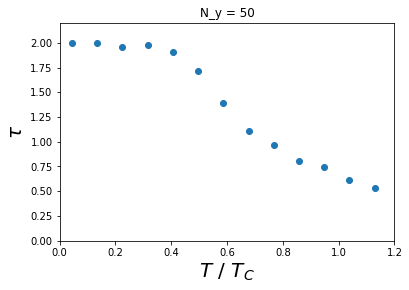

In [388]:
plt.scatter(t/Tc, -tau[:,0])
# plt.fill_between(t/Tc, -e, -(e+s), alpha = 0.2)
# plt.fill_between(t/Tc, -e, (-e+s), alpha=  0.2)
plt.xlim(0,1.2)
plt.ylim(0,2.2)
plt.xlabel(fr"$T\ /\ T_C$", size=20)
plt.title(f"N_y = {N_size}")
plt.ylabel(fr"$\tau$", size = 20)

### Fig 4

In [379]:
N_list = np.arange(2, 32)

In [380]:
tau_f = np.array([-Tc * np.log(alternative_metropolis_mj(n, N_sweeps, Tc)[0]) for n in N_list])

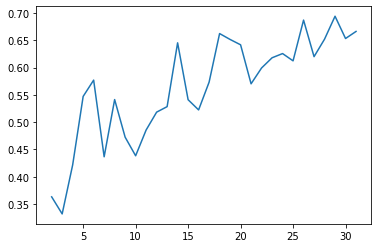

In [382]:
plt.plot(N_list, tau_f)